<h1>Load Dataset</h1>

In [1]:
import tensorflow as tf
from keras import utils, layers
from keras.layers import Dense,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import datetime
%load_ext tensorboard

In [2]:
img_height = 224
img_width = 224
num_classes = 4
batch_size = 16

In [3]:
data_train = utils.image_dataset_from_directory(
    "clean_dataset/train",
    labels="inferred",
    label_mode="int",
    class_names=["0","1","2","3"],
    color_mode="rgb",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 1572 files belonging to 4 classes.


In [4]:
data_val = utils.image_dataset_from_directory(
    "clean_dataset/val",
    labels="inferred",
    label_mode="int",
    class_names=["0","1","2","3"],
    color_mode="rgb",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 332 files belonging to 4 classes.


In [5]:
data_test = utils.image_dataset_from_directory(
    "clean_dataset/test",
    labels="inferred",
    label_mode="int",
    class_names=["0","1","2","3"],
    color_mode="rgb",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 332 files belonging to 4 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train = data_train.cache().prefetch(buffer_size=AUTOTUNE)
val = data_val.cache().prefetch(buffer_size=AUTOTUNE)
test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


<h1>Visualization of Samples</h1>

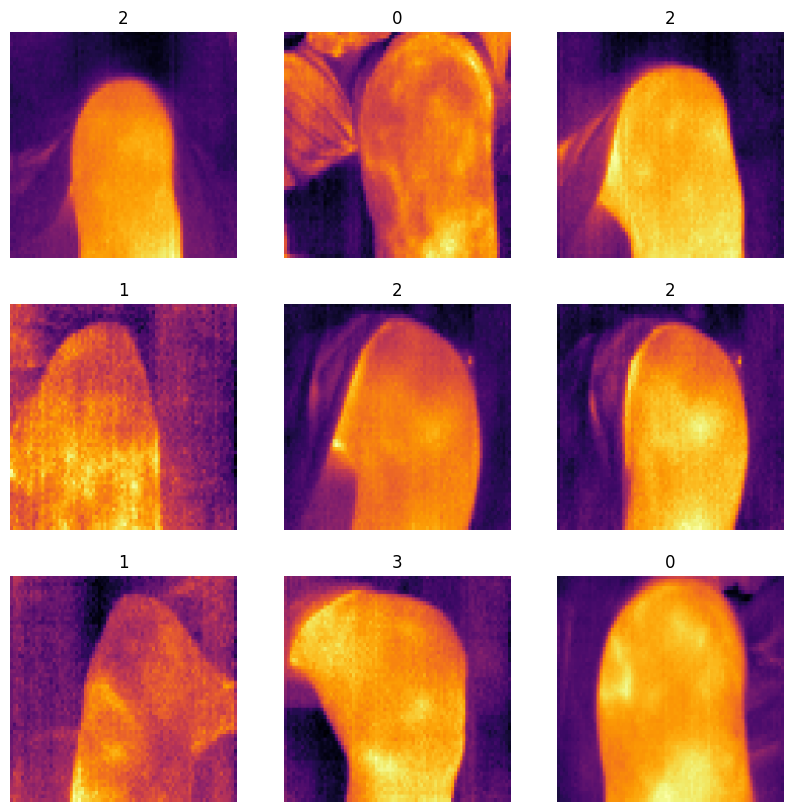

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1): 
  num_images_to_show = 9
  for i in range(num_images_to_show):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_train.class_names[labels[i]])
    plt.axis("off")
plt.show()

<h1>Neural Network Architecture</h1>

In [9]:
metrics = ["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]

In [ ]:
img_shape=(img_height, img_width, 3)
inputs = tf.keras.Input(shape=img_shape)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.GaussianNoise(0.02)
])
x = data_augmentation(inputs)


base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet", pooling="max", input_shape=img_shape)
base_model.trainable=False

x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(10, kernel_regularizer = regularizers.l2(0.02),activity_regularizer=regularizers.l1(0.02),
        bias_regularizer=regularizers.l1(0.02) ,activation="relu")(x)
x=Dropout(rate=.4)(x)


lr=.0001
outputs=Dense(num_classes, activation="softmax")(x)
model=Model(inputs=base_model.input, outputs=outputs)
model.compile(Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 947,238 (3.61 MB)

 Trainable params: 6,966 (27.21 KB)

 Non-trainable params: 940,272 (3.59 MB)

In [12]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
epochs = 100
history = model.fit(train,
                    validation_data=val,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[early_stopping,tensorboard_callback])

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.2910 - loss: 4.2887 - val_accuracy: 0.3042 - val_loss: 4.1470
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3336 - loss: 3.8155 - val_accuracy: 0.3946 - val_loss: 3.3720
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3892 - loss: 3.4651 - val_accuracy: 0.4940 - val_loss: 3.1038
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4149 - loss: 3.2301 - val_accuracy: 0.5392 - val_loss: 2.9338
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4402 - loss: 3.0626 - val_accuracy: 0.5904 - val_loss: 2.7982
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.4827 - loss: 2.8911 - val_accuracy: 0.6295 - val_loss: 2.6840
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5209 - loss: 2.7742 - val_accuracy: 0.6506 - val_loss: 2.5843
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5352 - loss: 2.6522 - val_accuracy: 0

<h1>Metrics</h1>

In [13]:
loss, accuracy = model.evaluate(train)

99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9543 - loss: 1.2759


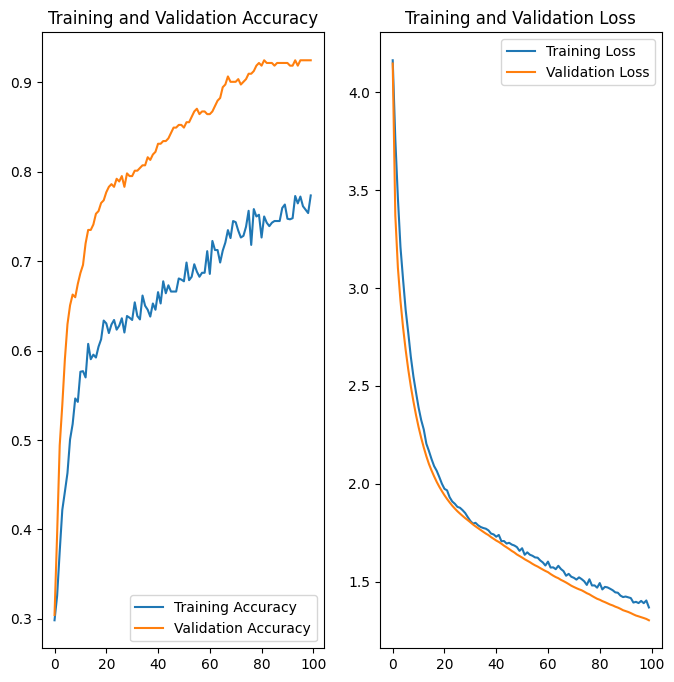

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

NOTE: As of this commit, we now use the keras v3 format to save the model. The old model files will no longer work and are deprecated. 

In [48]:
import numpy as np
import tensorflow as tf
import keras

MODEL_PATH = "tf-osteo.keras"

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model loaded successfully from {MODEL_PATH}")

except Exception as e:
    print(f"Error loading model from {MODEL_PATH}: {e}")

Model loaded successfully from tf-osteo.keras


In [46]:
model.save("tf-osteo.keras")